In [168]:
import pandas as pd
import datetime
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sma
from sklearn.metrics import r2_score

In [169]:
engagement = pd.read_csv("takehome_user_engagement.csv")

In [170]:
engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [171]:
# The 'visited' column contains only 1's and therefore does not provide useful information for this analysis.
engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [172]:
# Number of users of the 12000 total who logged in at least once.
len(engagement.user_id.unique())

8823

In [173]:
# The original file has characters with bad encoding. One way to fix the problem is to run the following on
# the command line:
# iconv -f utf-8 -t utf-8 -c "takehome_users.csv" > "takehome_users_clean.csv"

# A better solution is to read the file with a different encoding. utf-8 is the default.
users = pd.read_csv("takehome_users.csv",encoding="latin1")

In [174]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


The next thing we need to do is figure out which users are "adopted", which for the purposes of this exercise is defined as those users who have logged in three times in a one week period.

## For the purposes of this exercise, 'adopted' means that the user logged in three times within a week.

We want to understand how this variable can be determined from other information.

In [175]:
# Assumptions: for a given user, all login times are stored in chronological order
def adopted(user_id):
    logins = engagement[engagement["user_id"]==user_id]["time_stamp"]
    for i in range(len(logins)-2):
        delta = pd.to_datetime(logins.iloc[i+2])-pd.to_datetime(logins.iloc[i])
        if delta < datetime.timedelta(days=7):
            return 1
    return 0

In [176]:
users["adopted"] = users["object_id"].apply(adopted)

In [177]:
users["adopted"].value_counts()

0    10398
1     1602
Name: adopted, dtype: int64

In [178]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted'],
      dtype='object')

## Check if three variables: creation source, whether the user opted into the mailing list, and whether the user oped for the marketing drip campaign, are correlated with adoption.

In [179]:
users.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [180]:
# What portion of users are adopted by creation source?
# Users with source "PERSONAL_PROJECTS" are significantly less likely to be adopted than from other sources.
users[["creation_source","adopted"]].groupby('creation_source').mean()

,adopted
creation_source,
GUEST_INVITE,0.166436
ORG_INVITE,0.129995
PERSONAL_PROJECTS,0.077688
SIGNUP,0.140393
SIGNUP_GOOGLE_AUTH,0.167509


In [181]:
users[["opted_in_to_mailing_list","adopted"]].groupby('opted_in_to_mailing_list').mean()

,adopted
opted_in_to_mailing_list,
0,0.131912
1,0.138277


In [182]:
users[["enabled_for_marketing_drip","adopted"]].groupby('enabled_for_marketing_drip').mean()

,adopted
enabled_for_marketing_drip,
0,0.132837
1,0.137277


The f-statistic, which is the `statistic` variable below, is the ratio between the variation within classes to the variation between classes. The larger this value, the more likely that the difference is due to actual variation between classes and not merely chance.

The `pvalue` variable is the p-value for difference in means. We generally consider a threshold of 0.05. With `pvalue < 0.05`, we conclude that the variation is likely due to actual difference in means between variables. Otherwise, we cannot make such a conclusion.

In [183]:
md0 = users[users["enabled_for_marketing_drip"]==0]["adopted"]
md1 = users[users["enabled_for_marketing_drip"]==1]["adopted"]
statistic, pvalue = f_oneway(md0, md1)
print("p-value:",pvalue)
print("f-statistic:",statistic)

# High p value, so we cannot conclude that the means are different.

p-value: 0.6103198747560203
f-statistic: 0.25972302912447254


In [184]:
cs0 = users[users["creation_source"]=="GUEST_INVITE"]["adopted"]
cs1 = users[users["creation_source"]=="ORG_INVITE"]["adopted"]
cs2 = users[users["creation_source"]=="PERSONAL_PROJECTS"]["adopted"]
cs3 = users[users["creation_source"]=="SIGNUP"]["adopted"]
cs4 = users[users["creation_source"]=="SIGNUP_GOOGLE_AUTH"]["adopted"]
statistic, pvalue = f_oneway(cs0, cs1, cs2, cs3, cs4)
print("Five creation sources")
print("p-value:",pvalue)
print("f-statistic:",statistic)
print("\n")

# Low p-value, so we can conclude that not all means are the same.

statistic, pvalue = f_oneway(cs0, cs1, cs3, cs4)
print("Four creation sources (all but personal projects)")
print("p-value:",pvalue)
print("f-statistic:",statistic)

# Even if we ignore personal projects, the variation in the 'adopted' rate
# among creation sources is great enough to conclude that there is an actual difference.

Five creation sources
p-value: 3.671202580293534e-19
f-statistic: 23.240273648316546


Four creation sources (all but personal projects)
p-value: 7.493473734000719e-05
f-statistic: 7.244406933746679


In [185]:
ml0 = users[users["opted_in_to_mailing_list"]==0]["adopted"]
ml1 = users[users["opted_in_to_mailing_list"]==1]["adopted"]
statistic, pvalue = f_oneway(ml0, ml1)
print("p-value:",pvalue)
print("f-statistic:",statistic)
# High p-value, so we cannot conclude that the means are different.

p-value: 0.37510254183308966
f-statistic: 0.7867496832640625


## Linear Regression

First, set up a modified data set that is amenable to linear regression.

In [186]:
modified_users = users.drop(
    columns=["object_id","name","email","last_session_creation_time","invited_by_user_id","org_id"]
)
modified_users = modified_users.join(pd.get_dummies(modified_users['creation_source']))
# Dropping one of the creation sources to avoid linear dependence.
modified_users.drop(columns=["creation_source","SIGNUP_GOOGLE_AUTH"],inplace=True)
modified_users["creation_time"] = pd.to_datetime(modified_users["creation_time"])
# The new creation time is the number of days since January 1, AD 1. Time of day is ignored.
# This value is normalized to mean 0 and variance 1.
modified_users["creation_time"] = modified_users.creation_time.apply(lambda x: x.toordinal())
modified_users["creation_time"] = \
    (modified_users["creation_time"] - modified_users["creation_time"].mean()) / modified_users["creation_time"].std()

In [187]:
modified_users

,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP
0,1.292196,1,0,0,1,0,0,0
1,0.562880,0,0,1,0,1,0,0
2,-0.549557,0,0,0,0,1,0,0
3,-0.258754,0,0,0,1,0,0,0
4,-0.831128,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
11995,0.239766,0,0,0,0,1,0,0
11996,-0.863440,0,0,0,0,0,0,0
11997,1.315275,1,1,0,1,0,0,0
11998,-1.897406,0,0,0,0,0,1,0


In [188]:
X,y = modified_users.drop(columns=["adopted"]), modified_users["adopted"]

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42, stratify=y)

Now, the regression.

In [190]:
reg = LinearRegression().fit(X_train, y_train)

In [191]:
# Using stats model, see significance of coefficients for regression
X_train_const = sma.add_constant(X_train)
est = sma.OLS(y_train, X_train_const)
est2 = est.fit()
print(est2.summary())

# The summary demonstrates that creation_time, ORG_INVITE, PERSONAL_PROJECTS are significant.

                            OLS Regression Results                            
Dep. Variable:                adopted   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     21.82
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           1.92e-29
Time:                        23:20:27   Log-Likelihood:                -3193.9
No. Observations:                9600   AIC:                             6404.
Df Residuals:                    9592   BIC:                             6461.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [192]:
coefficients = {X.columns[i]: reg.coef_[i] for i in range(len(X.columns))}
coefficients

{'creation_time': -0.031410883792497866,
 'opted_in_to_mailing_list': 0.0031535476831538595,
 'enabled_for_marketing_drip': -0.0004927555495426233,
 'GUEST_INVITE': 0.004003496226164247,
 'ORG_INVITE': -0.025934207105873984,
 'PERSONAL_PROJECTS': -0.08501487771990807,
 'SIGNUP': -0.020160343217321033}

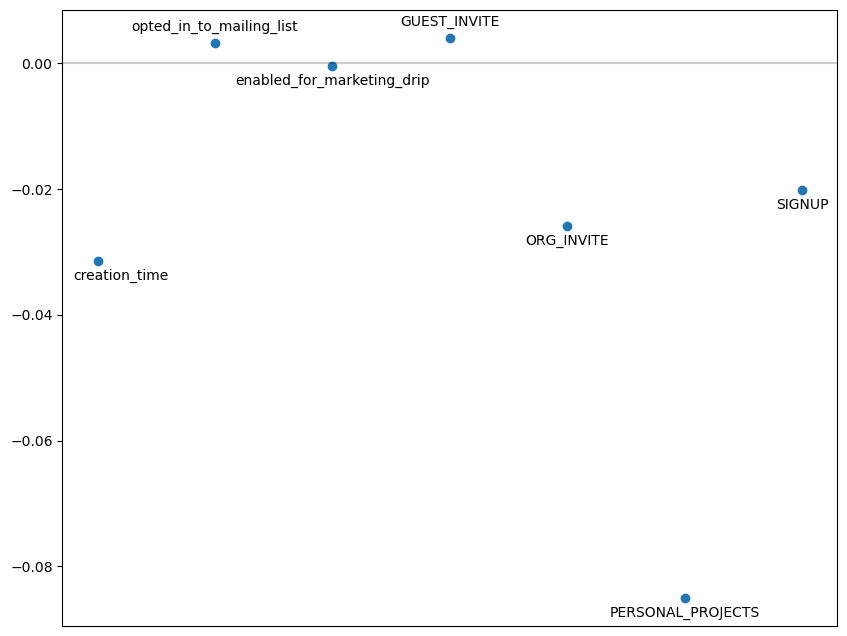

In [193]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(X.columns, reg.coef_, marker="o", linestyle='None')
for i in range(len(X.columns)):
    y_offset = -0.003
    x_offset = 0
    if i == 0:
        x_offset = 0.2
    if reg.coef_[i] > 0:
        y_offset = 0.002
    plt.annotate(xy=(x_offset+i, y_offset+reg.coef_[i]),text=X.columns[i],ha="center")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.axhline(y=0, color='black', alpha=0.2, linestyle='-')

In [194]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
print("Train R^2:",r2_score(y_train, y_train_pred))
print("Test R^2: ",r2_score(y_test, y_test_pred))

Train R^2: 0.015671021388690143
Test R^2:  0.01539887615888813


R<sup>2</sup> scores are low for both the test and training sets.